In [1]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

In [2]:
# size of training data set
training_size = 100
# dimension of data sets
n = 4
from sklearn import datasets
from sklearn import preprocessing
iris = datasets.load_iris()
# load iris and normalise
x = preprocessing.normalize(iris.data)
x1_train = x[0:49, :] # class A
x2_train = x[50:99, :] # class B
training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [3]:
sv = Statevector.from_label('0' * n)

In [4]:
def final_circuit(circuit, data, params):
    for i in range(n):
        circuit.h(i)
        circuit.rz(data[i], i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i, j)
            circuit.rz((np.pi-data[i])*(np.pi-data[j]), j)
            circuit.cx(i, j)
            circuit.barrier()
            
    for i in range(n):
        circuit.ry(params[i],i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i,j)
    circuit.barrier()
    
    for i in range(n):
        circuit.rz(data[i], i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i, j)
            circuit.rz((np.pi-data[i])*(np.pi-data[j]), j)
            circuit.cx(i, j)
            circuit.barrier()
            
    for i in range(n):
        circuit.ry(params[i+4],i)
        
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i,j)
    circuit.barrier()
    
    for i in range(n):
        circuit.rz(data[i], i)
    
    for i in range(n-1):
        for j in range(i+1, n):
            circuit.cx(i, j)
            circuit.rz((np.pi-data[i])*(np.pi-data[j]), j)
            circuit.cx(i, j)
            circuit.barrier()
            
    for i in range(n):
        circuit.ry(params[i+8],i)

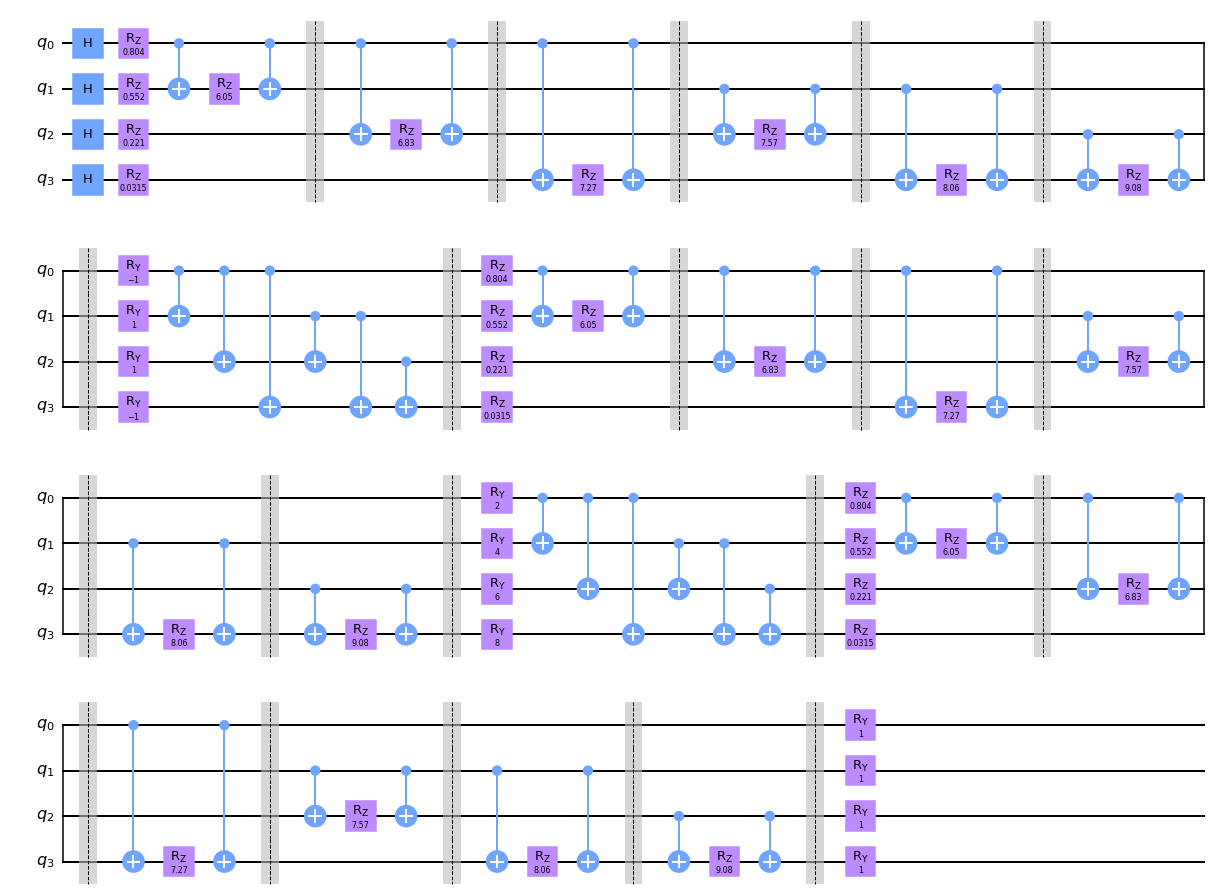

In [5]:
cir = QuantumCircuit(n)
final_circuit(cir, x[0], [-1,1,1,-1,2,4,6,8,1,1,1,1])
cir.draw('mpl')

In [6]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 12   # num of trainable params
for i in range(90,100,1):
    print(i)
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,d)
    print(init_params)
    # train classifier
    #init_params = np.random.uniform(-1,1,2)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'Layer3Hard4q/quantum_loss_hard_layer3_%d.npy' %i
    f2 = 'Layer3Hard4q/opt_params_hard_layer3_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

90
[-0.6938916  -0.68462868  0.97098223  0.80899546 -0.62784347 -0.46458097
 -0.33189769  0.28918374 -0.49718552  0.27041277  0.15959556  0.23762245]
[0.5736542449330408, 0.5030070644193151, 0.4703867377120091, 0.4466023657507849, 0.42267405697248867, 0.3966222520168039, 0.36956555927482054, 0.3446396504210675, 0.32471679310613605, 0.3104278659119289, 0.30012994064617465, 0.2918483439744894, 0.28492159802625855, 0.2797358230106408, 0.2764941062207568, 0.2744411643115093, 0.27215598953699877, 0.26856175083381256, 0.26365217253383016, 0.25841884314659236, 0.2542154037635493, 0.25201374474460436, 0.25198231200947296, 0.25348046056661205, 0.2552841347389552, 0.2560630420442297, 0.2550244067976438, 0.25225960504151407, 0.2485426700367303, 0.24483691131985308, 0.24187961527693924, 0.24000963593463864, 0.2391939714795603, 0.23914803963654446, 0.23947910393886593, 0.23981768473304663, 0.23991558925989753, 0.23969316961617365, 0.23922397200216788, 0.2386643505075342, 0.23816402815309412, 0.2378

[0.701364919372531, 0.6137637737475146, 0.5402023886376065, 0.47512051201959116, 0.41683546304771724, 0.36507891303698703, 0.3223354231621115, 0.2894280664432546, 0.2652507252548217, 0.24717094916705865, 0.23251953790053087, 0.22039916147112604, 0.21120455129279123, 0.20532105816066548, 0.20215332235435046, 0.20010913018811105, 0.1975331585028735, 0.19366151573234, 0.1886871416643136, 0.18320175475646794, 0.1777425947026567, 0.17264666540894105, 0.16805877164040658, 0.16398654040409613, 0.16038109046515356, 0.157212166896137, 0.15451137218151814, 0.1523849592655299, 0.15095607597673727, 0.15023255909591163, 0.15001796890640673, 0.149956323176489, 0.1496894845511745, 0.14902576066115283, 0.14801767250097028, 0.1469154173807128, 0.14601029227223186, 0.14543219190637405, 0.14504096639638092, 0.1445142444939057, 0.14357116466215775, 0.1421620146917935, 0.14050032814218225, 0.1389390205972784, 0.13778262079834466, 0.13714665002466978, 0.13693501508500197, 0.13693127388911178, 0.136933383038

[0.5526214808067413, 0.5124062326137142, 0.48617650588082145, 0.45605356146013865, 0.4250947547048893, 0.3963534978346102, 0.36955165580696064, 0.34232391980944055, 0.3124359438069485, 0.2826348832573288, 0.25834376648308405, 0.24326440542424582, 0.23712248546759898, 0.23652786868380757, 0.2376548900546984, 0.2381524047672824, 0.23735764365682005, 0.23531116620683004, 0.23164080606800602, 0.225410341898748, 0.21598823810740125, 0.20383816511871755, 0.19044493534640858, 0.1776270989208571, 0.16692762525965452, 0.15937972438264478, 0.1554162315960935, 0.15481554210615397, 0.1567888262482898, 0.16021029223763963, 0.16389529420440718, 0.16684279802144364, 0.16838435169612742, 0.1682207365422451, 0.1664023873336263, 0.1633018717327934, 0.15953599470962745, 0.15580067771812675, 0.15267272748408783, 0.15046012878520743, 0.149149808403128, 0.14847601694732762, 0.1480918911007668, 0.1477481622288372, 0.1473536545954918, 0.1468903472230744, 0.14630028804504952, 0.14548616260738118, 0.14442196766

In [8]:
loss_eqnn_d1 = np.load('Layer3Hard4q/quantum_loss_hard_layer3_1.npy')

In [9]:
loss_eqnn_d1.shape

(100,)

In [10]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Layer3Hard4q/quantum_loss_hard_layer3_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [11]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training - 3 Layer (Data Reuploading, Qubits = 4, Hard Model)')

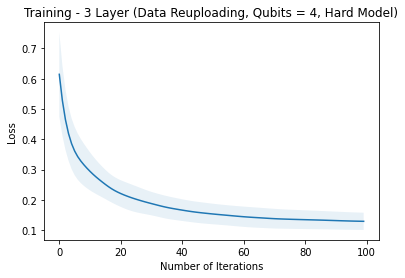

In [12]:
import matplotlib.pyplot as plt
groen = np.array([0,208,0])/255
stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 3 Layer (Data Reuploading, Qubits = 4, Hard Model)")

In [13]:
losseasy = np.zeros((100,100))
for i in range(100):
    file = 'Layer3Easy4q/quantum_loss_easy_layer34q_%d.npy'%i
    losseasy[i] += np.load(file, allow_pickle=True)

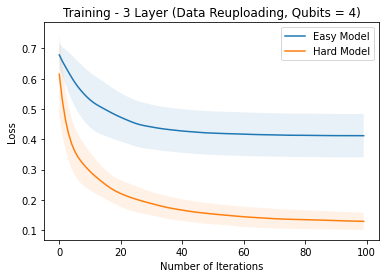

In [15]:
stddevs =[]
averages =[]
sde = np.std(losseasy, axis=0)
ave = np.average(losseasy, axis=0)
plt.plot(range(100), ave)
plt.fill_between(range(100), ave+np.array(sde), ave-np.array(sde), alpha=0.1)
stddevs.append(sde)
averages.append(ave)

plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)

plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training - 3 Layer (Data Reuploading, Qubits = 4)")

legendList = ['{}'.format(i) for i in ["Easy Model", "Hard Model"]]
plt.legend(legendList)